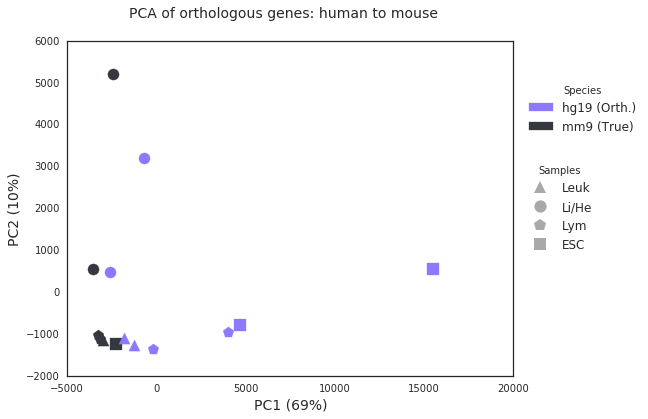

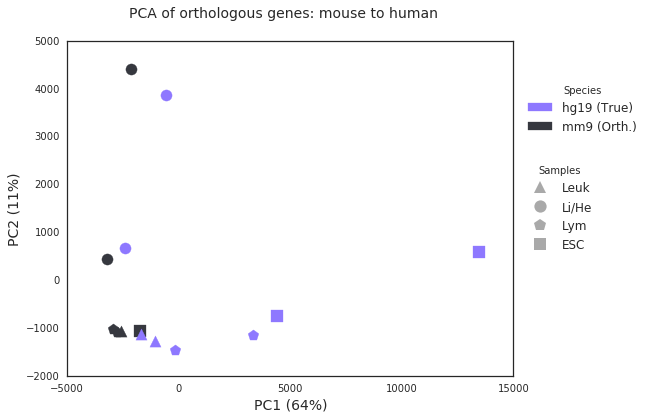

In [75]:
%matplotlib inline

import os as os
import numpy as np
import json as js
import pandas as pd
import sklearn.decomposition as decomp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

sns.set_style('white')

data_folder = '/TL/deep/fhgfs/projects/pebert/thesis/refdata/orthologs/hdf'

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

# 'true_TE12_mm9_liver_mRNA', 'orth_TD21_hg19_hepa_mRNA'
def annotate_samples(samples):
    """
    """
    annotation = dict()
    for s in samples:
        src, _, assm, bio, _ = s.split('_')
        color = plot_colors['assembly'][assm]['rgb']
        shape = plot_shapes[bio]
        label = plot_labels[bio]
        if src == 'true':
            src = 'True'
        else:
            src = 'Orth.'
        annotation[s] = {'color': color, 'label': label,
                         'shape': shape, 'source': src, 'assm': assm}
    return annotation
        
        


def plot_heatmap(df, title):
    """
    """
    col_ann = annotate_samples(df.columns)
    col_labels = []
    for c in df.columns:
        ann = col_ann[c]
        new_label = '{}_{}_{}'.format(ann['label'], ann['assm'], ann['source'])
    df.columns = col_labels
    df = np.log1p(df)
    if df.shape[1] > 2:
        cm = sns.clustermap(df, method='average', metric='euclidean',
                            row_cluster=True, col_cluster=True, figsize=(15, 15),
                            cmap="Reds", yticklabels=False)
    else:
        cm = sns.clustermap(df, method='average', metric='euclidean',
                            row_cluster=True, col_cluster=False, figsize=(15, 15),
                            cmap="Reds", yticklabels=False)
    plt.suptitle(title)
    sns.plt.show()
    #cm.savefig(outfile, dpi=300)
    return


def plot_pca_scatter(df, title):
    """
    """
    df = df.transpose()
    sample_ann = annotate_samples(df.index)
    labels, colors, shapes = [], [], []
    leg_spec = set()
    leg_shape = set()
    for sample in df.index:
        ann = sample_ann[sample]
        labels.append(ann['label'])
        colors.append(ann['color'])
        shapes.append(ann['shape'])
        leg_spec.add((ann['assm'], tuple(ann['color']), ann['source']))
        leg_shape.add((ann['shape'], ann['label']))
    leg_spec = sorted(leg_spec)
    leg_shape = sorted(leg_shape)
    pca_red = decomp.PCA(n_components=0.9)
    red_data = pca_red.fit_transform(df)
    
    comp_x = 0
    comp_y = 1
    
    fig, ax = plt.subplots(figsize=(8, 6))
    for x, y, c, l, m in zip(red_data[:, comp_x], red_data[:, comp_y], colors, labels, shapes):
        plt.scatter(x, y, color=c, label=l, marker=m, s=125)
    
    # legend for bio sample
    shape_handles = []
    for s, l in leg_shape:
        shape_handles.append(plt.Line2D([], [], marker=s, linestyle='',
                                        label=l, c='darkgray'))
    leg_sample = plt.legend(handles=shape_handles, loc=7, title='Samples', markerscale=1.75,
                            fontsize=12, bbox_to_anchor=(1.2, 0.5))
    ax = plt.gca().add_artist(leg_sample)
    # legend for species
    leg_patch1 = mpatches.Patch(color=leg_spec[0][1], label=leg_spec[0][0] + ' ({})'.format(leg_spec[0][2]))
    leg_patch2 = mpatches.Patch(color=leg_spec[1][1], label=leg_spec[1][0] + ' ({})'.format(leg_spec[1][2]))
    plt.legend(handles=[leg_patch1, leg_patch2], loc=1, title='Species',
               markerscale=1.5, fontsize=12, bbox_to_anchor=(1.3, 0.9))
    
    
    plt.suptitle('PCA of orthologous genes: ' + title, fontsize=14)
    expvar = pca_red.explained_variance_ratio_
    plt.xlabel('PC{} ({}%)'.format(comp_x + 1, int(np.round(expvar[comp_x] * 100, 0))), fontsize=14)
    plt.ylabel('PC{} ({}%)'.format(comp_y + 1, int(np.round(expvar[comp_y] * 100, 0))), fontsize=14)
    return


opfile = os.path.join(data_folder, 'hg19_mm9_ortho-pred.h5')

with pd.HDFStore(opfile, 'r') as hdf:
    for group, title in zip(['/AB/hg19/mm9', '/BA/mm9/hg19'],
                            ['human to mouse', 'mouse to human']):
        #plot_heatmap(hdf[group], title)
        plot_pca_scatter(hdf[group], title)
